<a href="https://colab.research.google.com/github/moeinghaeini/Audio-Pattern-Recognition/blob/main/Extract_MFCCs__For__Genre_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import json
import os
import math
import librosa
from sklearn.preprocessing import LabelEncoder

In [3]:
DATASET_PATH = "/content/drive/MyDrive/University of Milan/Audio Pattern Recognition/Dataset/genres_original"
JSON_PATH = "/content/drive/MyDrive/University of Milan/Audio Pattern Recognition/Data_kmeans.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds (Eack track in out dataset in 30Sec)
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION


def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    """Extracts MFCCs from music dataset and saves them into a json file along witgh genre labels.

        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save MFCCs
        :param num_mfcc (int): Number of coefficients to extract
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into. => To increase the number of training tracks.
        :return:
        """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],  #for example: list:["classical","blues",...] => classical is mappied to 0 and blues to 1. => each genre is mapped to its coresponding index in the list.
        "labels": [], #These are the outputs => is a list : [0, 1, 0] => it is coresponding results to the below list of MFCCs => it says that the first list of MFCCs is classical.
        "mfcc": []  #These are the inputs => is a list : [[...], [...], [...], ... ]
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)  #ceil function: round the number to its higher inter: (1.2 => 2)

    # **********At the end of this "for" loop, we are gonna have all the ganres ("mapping" variable), also the MFCCs for each segment, and the labels for each segments.
    # loop through all genre sub-folder => At each iteration of i, we are in different genre =>but=> the first iteration is for dataset_path
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):  #dirpath: current folder / dirnames: all the subfolders in current folder / filenames: all the files in current folder

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path: #Ensure we are nit at the root level

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]   #If we are in genre/blues => ["genre","blues"]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

		            #1. load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                #2. process all segments of audio file
                for d in range(num_segments):   # => d: the current segment that we are in => d=0 is the first segment

                    #2.1. calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    #2.2. extract mfcc *********************** #we process a slice of the signal between (start sample< <finish sample)
                    mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T # Transpose to have time-steps as rows

                    #2.3. store only mfcc feature with expected number of vectors (As some tracks may not be exactly 30 seconds => the last segment may be shorter => but we need the ones with the exact segment size.)
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist()) #mfcc is numpy array and we need to convert it to list to be able to save it as json file and add it to our mfcc list
                        data["labels"].append(i-1)  #i-1: => the first iteration is for dataset_path
                        print("{}, segment:{}".format(file_path, d+1))

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

In [4]:
if __name__ == "__main__":
    save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/University of Milan/Audio Pattern Recognition/Dataset/genres_original/classical/classical.00091.wav, segment:9
/content/drive/MyDrive/University of Milan/Audio Pattern Recognition/Dataset/genres_original/classical/classical.00091.wav, segment:10

Processing: rock
/content/drive/MyDrive/University of Milan/Audio Pattern Recognition/Dataset/genres_original/rock/rock.00008.wav, segment:1
/content/drive/MyDrive/University of Milan/Audio Pattern Recognition/Dataset/genres_original/rock/rock.00008.wav, segment:2
/content/drive/MyDrive/University of Milan/Audio Pattern Recognition/Dataset/genres_original/rock/rock.00008.wav, segment:3
/content/drive/MyDrive/University of Milan/Audio Pattern Recognition/Dataset/genres_original/rock/rock.00008.wav, segment:4
/content/drive/MyDrive/University of Milan/Audio Pattern Recognition/Dataset/genres_original/rock/rock.00008.wav, segment:5
/content/drive/MyDrive/University of Milan

In [5]:
import pandas as pd

In [10]:
import json
JSON_PATH = "/content/drive/MyDrive/University of Milan/Audio Pattern Recognition/Data.json"
# Load the JSON file
with open(JSON_PATH, "r") as fp:
    data = json.load(fp)

# Access the class labels (genre labels)
class_labels = data["mapping"]

df = pd.DataFrame({'Genre': class_labels})



In [11]:
!pip install squarify
import matplotlib.pyplot as plt
import squarify

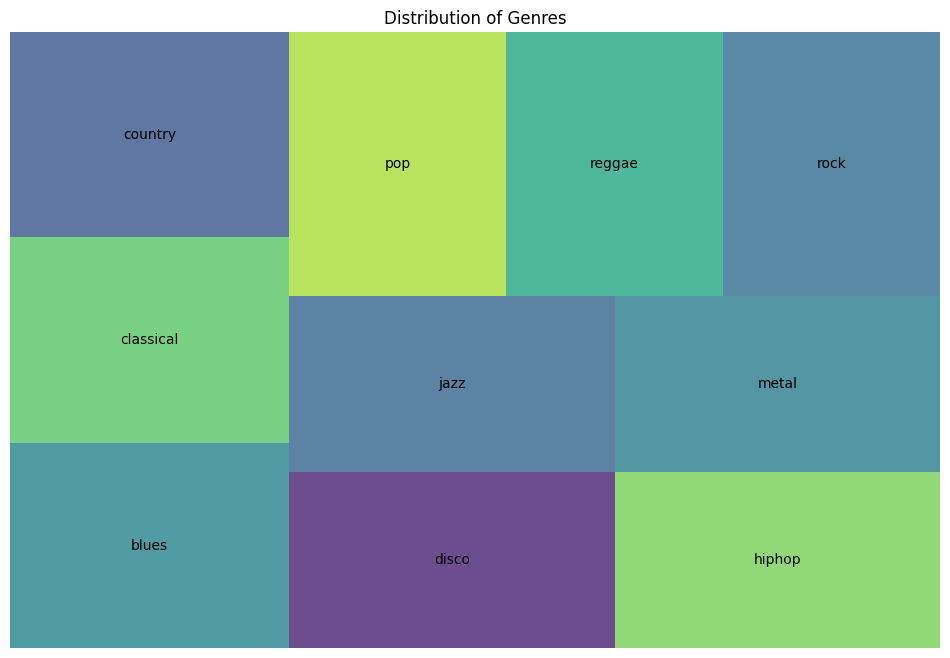

In [12]:
# Calculate the frequency of each genre
genre_counts = df['Genre'].value_counts()

# Create the treemap
plt.figure(figsize=(12, 8))
squarify.plot(sizes=genre_counts.values, label=genre_counts.index, alpha=.8 )
plt.title("Distribution of Genres")
plt.axis('off') # Hide the axes
plt.show()